In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from pathlib import Path
import os
import seaborn as sns
from keras import layers ,models
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import np_utils,plot_model
from sklearn.model_selection import train_test_split

In [2]:
(x_train, y_train), (x_test, y_test)= cifar10.load_data()
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

In [4]:
train_generator = train_datagen.flow(x=x_train, y=y_train, batch_size=32, shuffle=True)

test_generator = test_datagen.flow(x=x_test, y=y_test, batch_size=32, shuffle=True)

In [5]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def SqueezeNet(input_shape=(32,32,3), classes=10):

    img_input = layers.Input(shape=input_shape)


    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
#     x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    model = models.Model(img_input, out, name='squeezenet')

    return model

In [7]:
sn = SqueezeNet()
sn.summary()
sn.compile(optimizer='adam',    
                     loss='categorical_crossentropy',  
                     metrics=['accuracy'] ) 

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 15, 15, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 15, 15, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 fire2/squeeze1x1 (Conv2D)      (None, 15, 15, 16)   1040        ['relu_conv1[0][0]']             
                                                                                         

In [8]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='file_name/cp.h5',
                                              save_weights_only=False,  
                                              verbose=1,            
                                              monitor='val_accuracy', 
                                              save_best_only=True) 
EarlyStopping=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) 
callback_lists=[checkpoint]
history = sn.fit(train_generator,
                                validation_data=test_generator,
                                
                                epochs=200,
                                
                                verbose=True,
                                callbacks=callback_lists
                                )

Epoch 1/200
1559/1563 [============================>.] - ETA: 0s - loss: 1.8133 - accuracy: 0.3045
Epoch 1: val_accuracy improved from -inf to 0.42470, saving model to file_name\cp.h5
1563/1563 [==============================] - 22s 12ms/step - loss: 1.8132 - accuracy: 0.3046 - val_loss: 1.5335 - val_accuracy: 0.4247
Epoch 2/200
1559/1563 [============================>.] - ETA: 0s - loss: 1.4717 - accuracy: 0.4569
Epoch 2: val_accuracy improved from 0.42470 to 0.48780, saving model to file_name\cp.h5
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4714 - accuracy: 0.4571 - val_loss: 1.4161 - val_accuracy: 0.4878
Epoch 3/200
1560/1563 [============================>.] - ETA: 0s - loss: 1.2897 - accuracy: 0.5292
Epoch 3: val_accuracy improved from 0.48780 to 0.56310, saving model to file_name\cp.h5
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2894 - accuracy: 0.5293 - val_loss: 1.2078 - val_accuracy: 0.5631
Epoch 4/200
1561/1563 [==============

In [9]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

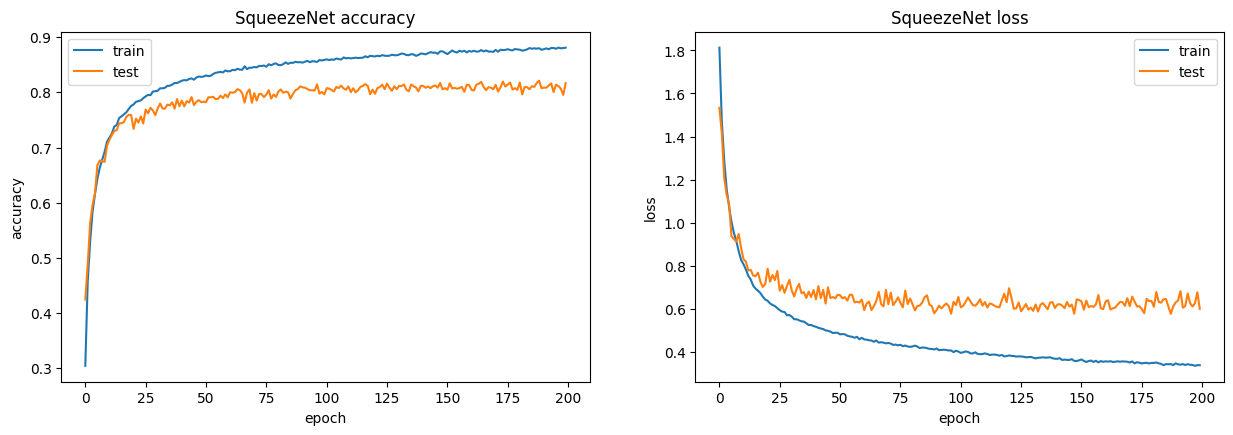

In [10]:
plot_accuracy_and_loss(history)

In [11]:
# save model architecture
model_json = sn.to_json()
open('squeeze_net_model.json', 'w').write(model_json)

# save model's learned weights
sn.save_weights('image_classifier_squeeze_net.h5', overwrite=True)